# Point clouds

We cover in this tutorial the instantiation and use of a `PointCloud` geometry. 

A `PointCloud` geometry holds two arrays of vectors, endowed with a cost function. Such a geometry should cover most users' needs. 

We further show differentiation through optimal transport as an example of optimization that leverages first-order gradients.

This Notebook can be run on either Jupyter Notebook or Colab (which requires running `! pip install ott-jax` first).

In [ ]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

## Creates a PointCloud geometry

In [ ]:
def create_points(rng, n, m, d):
  rngs = jax.random.split(rng, 3)
  x = jax.random.normal(rngs[0], (n,d)) + 1
  y = jax.random.uniform(rngs[1], (m,d))
  a = jnp.ones((n,)) / n
  b = jnp.ones((m,)) / m
  return x, y, a, b

rng = jax.random.PRNGKey(0)
n, m, d = 12, 14, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

## Computes the regularized optimal transport

To compute the transport matrix between the two point clouds, one can define a `PointCloud` geometry (which by default uses `ott.geometry.costs.Euclidean` for cost function), then call the `sinkhorn` function, and build the transport matrix from the optimized potentials.

In [ ]:
geom = pointcloud.PointCloud(x, y, epsilon=1e-2)
out = sinkhorn.sinkhorn(geom, a, b)
P = geom.transport_from_potentials(out.f, out.g)

A more concise syntax to compute the optimal transport matrix is to use the `Transport` interface. Note how weights are assumed to be uniform if no parameter `a` and `b` is passed to `Transport`. 

In [ ]:
ot = transport.Transport(x, y, epsilon=1e-2)

## Visualizes the transport

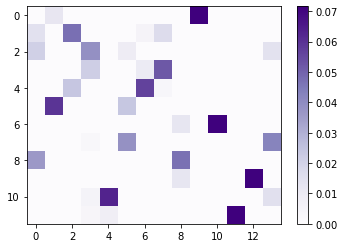

In [ ]:
plt.imshow(ot.matrix, cmap='Purples')
plt.colorbar()

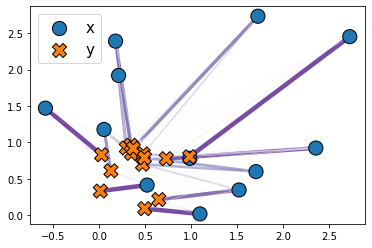

In [ ]:
plott = ott.tools.plot.Plot()
_ = plott(ot)

## Differentiation through Optimal Transport

OTT returns quantities that are differentiable. In the following example, we leverage the gradients to move `N` points 
in a way that minimizes the overall regularized OT cost, given a ground cost function, here the squared Euclidean distance.

In [ ]:
def optimize(x: jnp.ndarray,
             y: jnp.ndarray,
             a: jnp.ndarray,
             b: jnp.ndarray,
             cost_fn=ott.geometry.costs.Euclidean(),
             num_iter: int = 101,
             dump_every: int = 10,
             learning_rate: float = 0.2):  
  reg_ot_cost_vg = jax.value_and_grad(jax.jit(
    (lambda geom, a, b: ott.core.sinkhorn.sinkhorn(geom, a, b).reg_ot_cost)), 
    argnums=0)

  geom = ott.geometry.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
  ot = ott.tools.transport.Transport(geom, a=a, b=b, jit=True)
  result = [ot]
  for i in range(1, num_iter + 1):  
    reg_ot_cost, geom_g = reg_ot_cost_vg(ot.geom, ot.a, ot.b)
    x = x - geom_g.x * learning_rate
    geom = ott.geometry.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
    ot = ott.tools.transport.Transport(geom, a=a, b=b, jit=True)
    if i % dump_every == 0:
      result.append(ot)

  return result

In [109]:
from IPython import display

ots = optimize(x, y, a, b, num_iter=100, cost_fn=ott.geometry.costs.Euclidean())
fig = plt.figure(figsize=(8, 5))
plott = ott.tools.plot.Plot(fig=fig)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

We could use another cost function, in this case Cosine distance, to achieve another kind of  dynamics in optimization.

In [110]:
ots = optimize(x, y, a, b, num_iter=100, cost_fn=ott.geometry.costs.Cosine())
fig = plt.figure(figsize=(8, 5))
plott = ott.tools.plot.Plot(fig=fig)
anim = plott.animate(ots, frame_rate=8)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()